<a href="https://colab.research.google.com/github/mrdrew213/PyTorch/blob/main/helloworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Operations

Note: be sure to enable the GPU (edit -> Notebook Settings)!

1. Clone the git repo, but be sure to get the correct branch
2. Copy utilities from the repo to the local directory
3. Download preannotated dataset, extract
4. Download pytorch training code, used it
5. Train your model
6. Pick a random sample from the training set and try it
7. Grab an image from the internet and try that too!

In [ ]:
!git clone https://github.com/pytorch/vision.git --branch v0.8.2

In [2]:
!cp vision/references/detection/utils.py .
!cp vision/references/detection/transforms.py .
!cp vision/references/detection/coco_eval.py .
!cp vision/references/detection/engine.py .
!cp vision/references/detection/coco_utils.py .

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -qq PennFudanPed.zip

In [5]:
import os
import numpy as np
import torch
from PIL import Image

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

#import torch
from PIL import Image
import torchvision.transforms as transforms

from torchvision.utils import draw_bounding_boxes


In [ ]:
# Sample code from the TorchVision 0.3 Object Detection Finetuning Tutorial
# http://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")
    return model
    
if __name__ == "__main__":
    mymodel = main()

In [7]:
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# pick one image from the test set
img, _ = dataset_test[17]
# put the model in evaluation mode
mymodel.eval()
with torch.no_grad():
    prediction = mymodel([img.to(device)])



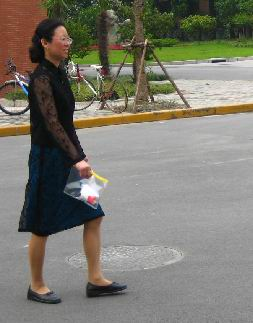

In [8]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

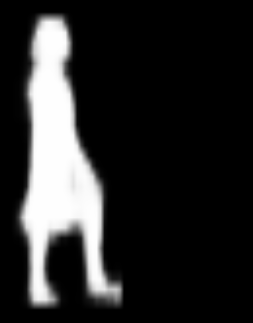

In [9]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [10]:
!wget https://ak.picdn.net/offset/photos/5b89688fdaee26d9e8c7937d/medium/photo.jpg

--2023-02-06 00:02:28--  https://ak.picdn.net/offset/photos/5b89688fdaee26d9e8c7937d/medium/photo.jpg
Resolving ak.picdn.net (ak.picdn.net)... 65.9.86.33, 65.9.86.2, 65.9.86.102, ...
Connecting to ak.picdn.net (ak.picdn.net)|65.9.86.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112606 (110K) [image/jpeg]
Saving to: ‘photo.jpg’

photo.jpg           100%[===================>] 109.97K  --.-KB/s    in 0.008s  

2023-02-06 00:02:28 (14.1 MB/s) - ‘photo.jpg’ saved [112606/112606]



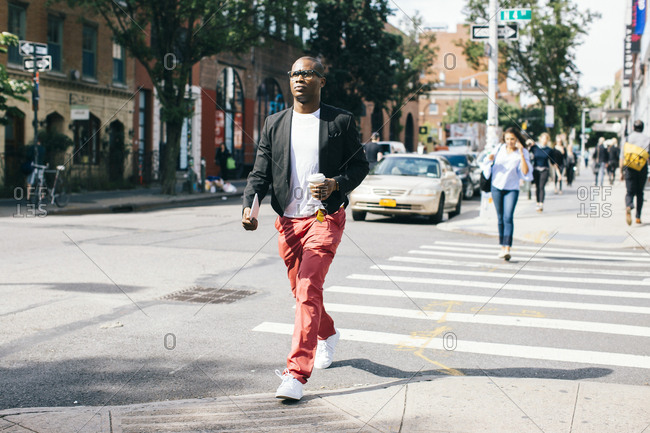

In [11]:
img = Image.open('photo.jpg')
img

In [12]:
# Import necessary libraries


# Define a transform to convert PIL 
# image to a Torch tensor
transform = transforms.Compose([
    transforms.PILToTensor()
])

 
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transform(img)
  
# print the converted Torch tensor
#print(img_tensor)
img_tensor_float=img_tensor/255
#print(img_tensor_float)

mymodel.eval()
with torch.no_grad():
    prediction = mymodel([img_tensor_float.to(device)])

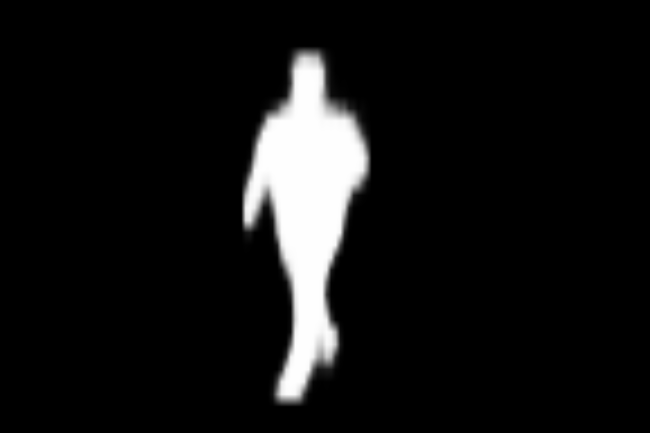

In [13]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [14]:


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

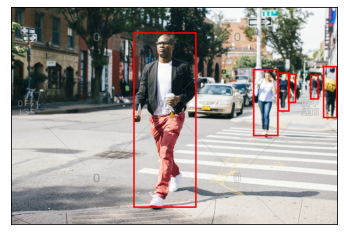

In [15]:
drawn_boxes = draw_bounding_boxes(img_tensor, prediction[0]['boxes'], colors="red", width=3)
show(drawn_boxes)